_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

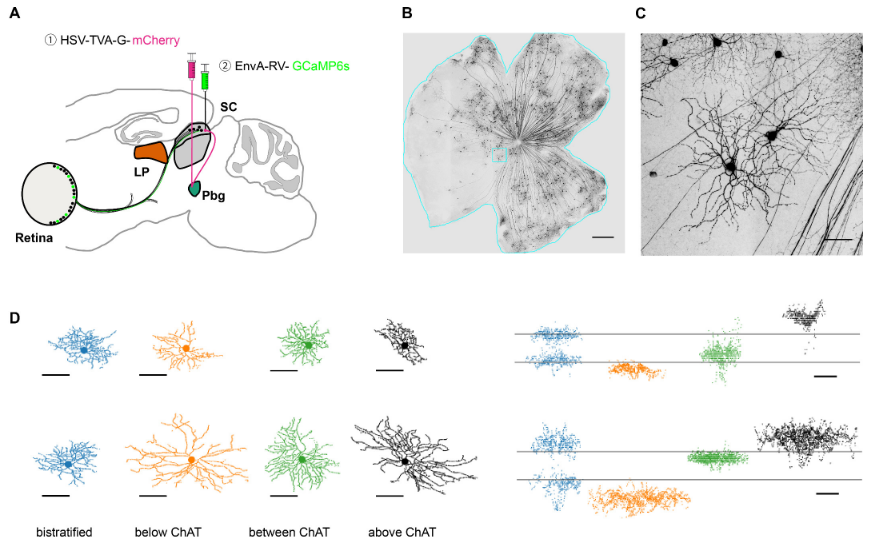

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [132]:
import pandas as pd
import numpy as np
import os

from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-22 14:59:30CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.37.0

sklearnv: not installed

matplotlib: 3.10.3
morphopy  : 0.7.2
pandas    : 2.3.0
seaborn   : 0.13.2
sklearn   : 1.7.0
openTSNE  : 1.0.2
numpy     : 2.2.6

Watermark: 2.5.0



In [133]:
plt.style.use(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/matplotlib_style.txt"
)

# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [134]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [135]:
# import swc file
PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [136]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

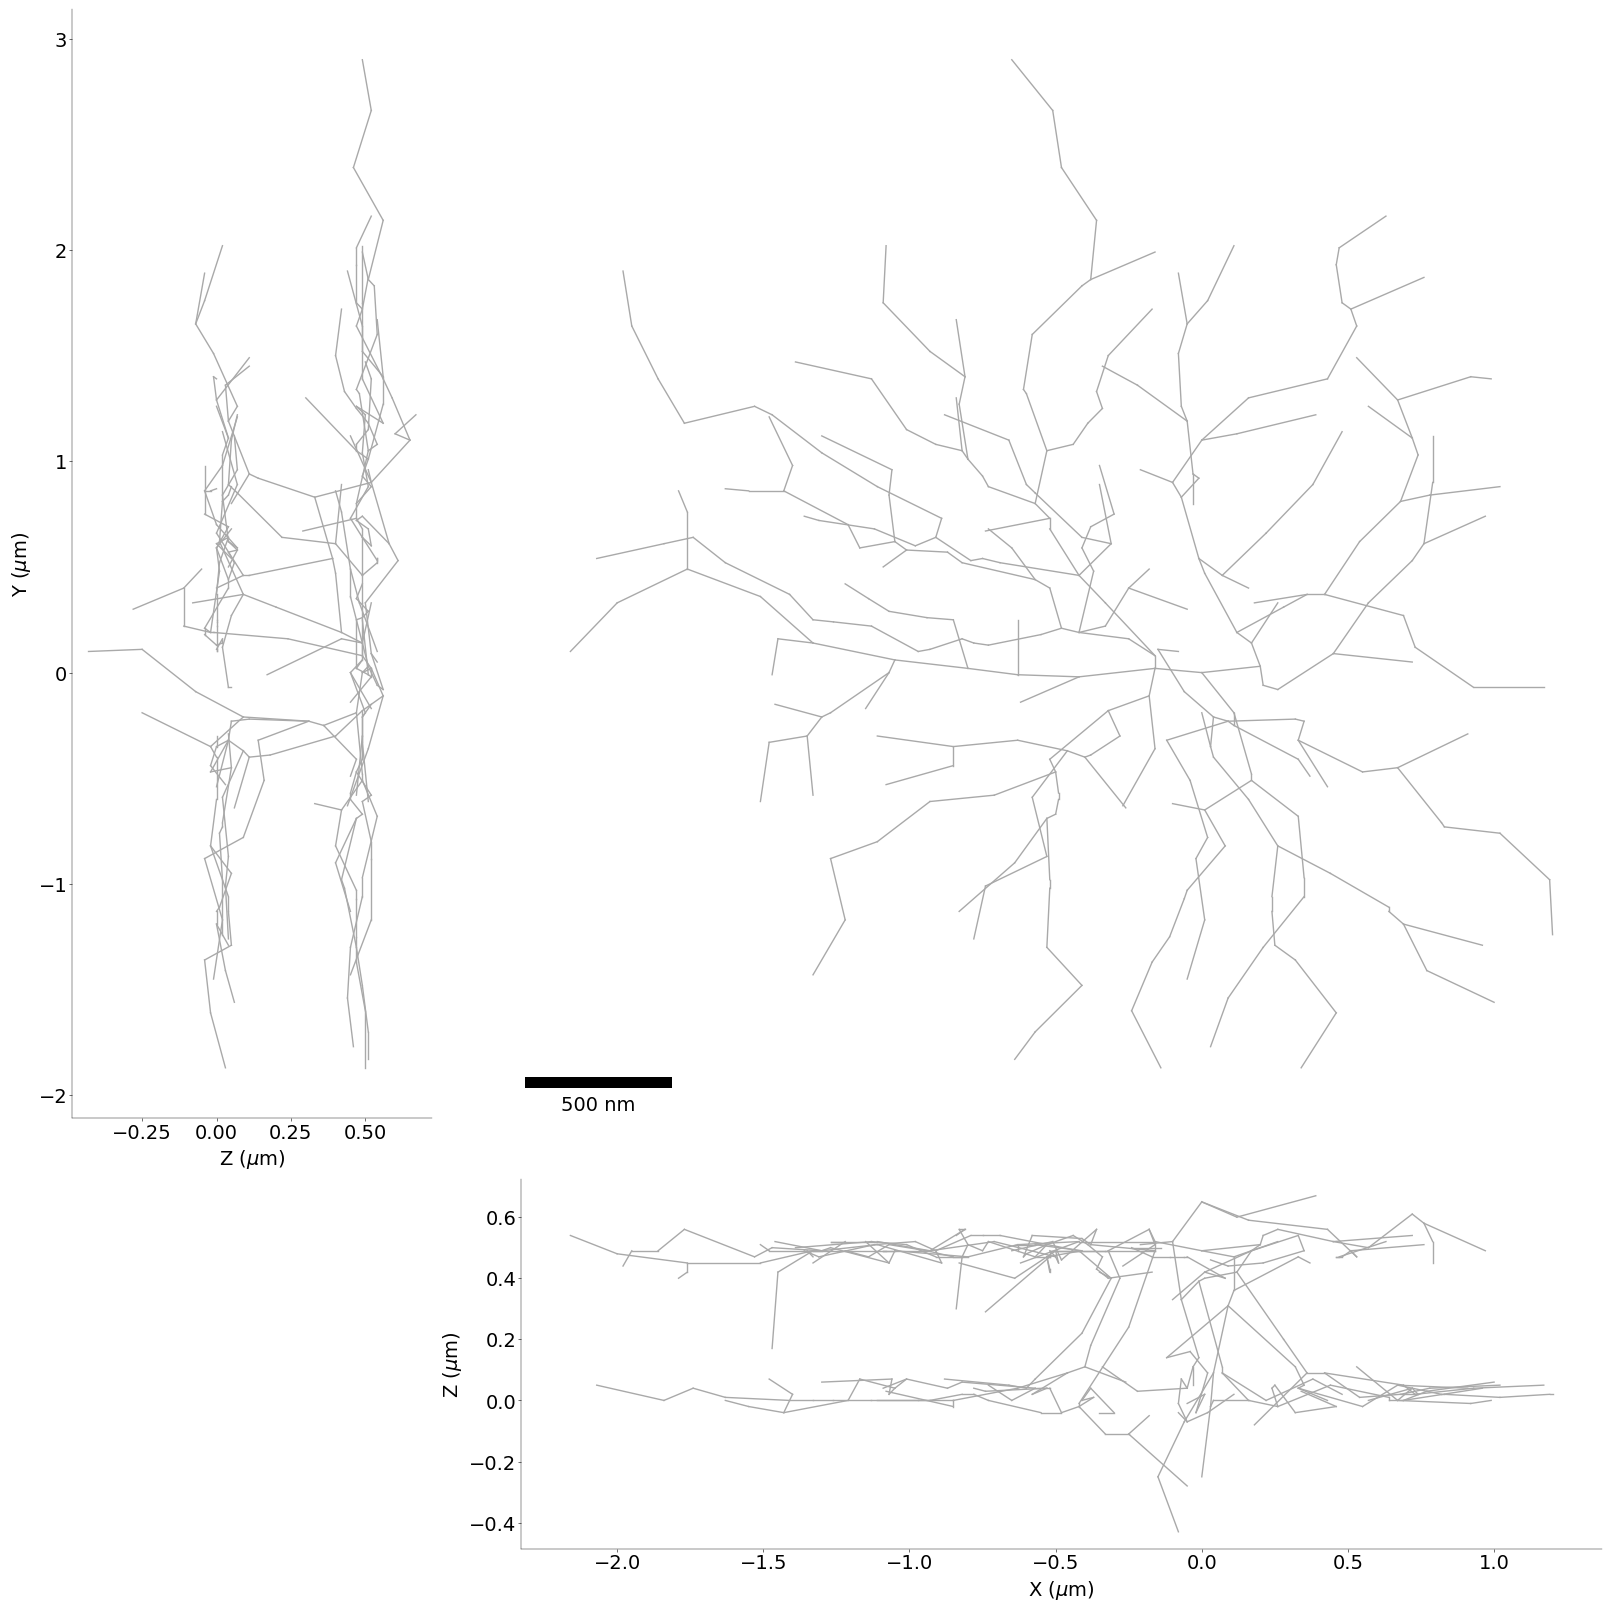

In [137]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------

cell_name = "0060_00556_3R_C02_01"
data_dir = "../data/nds_cl_8/reconstructions/soma-centered/"
swc_path = f"{data_dir}{cell_name}.swc"

neuron = file_manager.load_swc_file(swc_path, pca_rot=False, soma_center=False)

# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------

show_threeview(neuron)

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:**
- XY view (top-down): The neuron shows a broad, radially symmetric spread of dendrites — characteristic of retinal ganglion cells that integrate signals over a wide retinal area.
- YZ and XZ views (side projections): You can clearly observe two distinct dendritic strata within the Z axis (depth). These layers correspond to distinct sublaminae of the inner plexiform layer (IPL) in the retina
- This neuron shows a bistratified dendritic arbor — its dendrites stratify into two distinct sublayers of the inner plexiform layer.
The IPL is the synaptic layer of the retina, where different visual channels (ON vs. OFF) are separated by depth.

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [138]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    neurons = []
    # ----------------------------------------------------------
    # use `file_manager` to import all reconstructions (0.5 pts)
    # Note the list should be sorted by filename.
    # ----------------------------------------------------------

    # Get all .swc files and sort them
    files = sorted(f for f in os.listdir(path) if f.endswith(".swc"))

    if not files:
        print(f"No SWC files found in {path}")
        return neurons

    # Load each file into a NeuronTree object
    for fname in files:
        full_path = os.path.join(path, fname)
        neuron = file_manager.load_swc_file(full_path, pca_rot=False, soma_center=False)
        neurons.append(neuron)

    return neurons


data_path = "../data/nds_cl_8/reconstructions/soma-centered/"
neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [139]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics

# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------

ms_list = []
for fname, neuron in zip(sorted(os.listdir(data_path)), neurons):
    cell_nr = int(fname.split("_")[0])
    df = compute_morphometric_statistics(neuron)
    df.index = [cell_nr]
    ms_list.append(df)

# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr`` as index (0.5 pts)
# -----------------------------------------------------------------------------------

morphometric_statistics = pd.concat(ms_list, axis=0)
morphometric_statistics.index.name = "Cell_nr"

Now let's visualize the data.

In [140]:
# Merge labels into morphometric_statistics using Cell_nr
morphometric_with_clusters = morphometric_statistics.merge(
    labels[["Cell_nr", "cluster"]],
    left_index=True,
    right_on="Cell_nr",
    how="left",  # or 'left' if you want to keep all morphometric entries
)

# drop redundant Cell_nr column (since it's now index)
stats_with_labels = morphometric_with_clusters
stats_with_labels.drop(columns="Cell_nr", inplace=True)

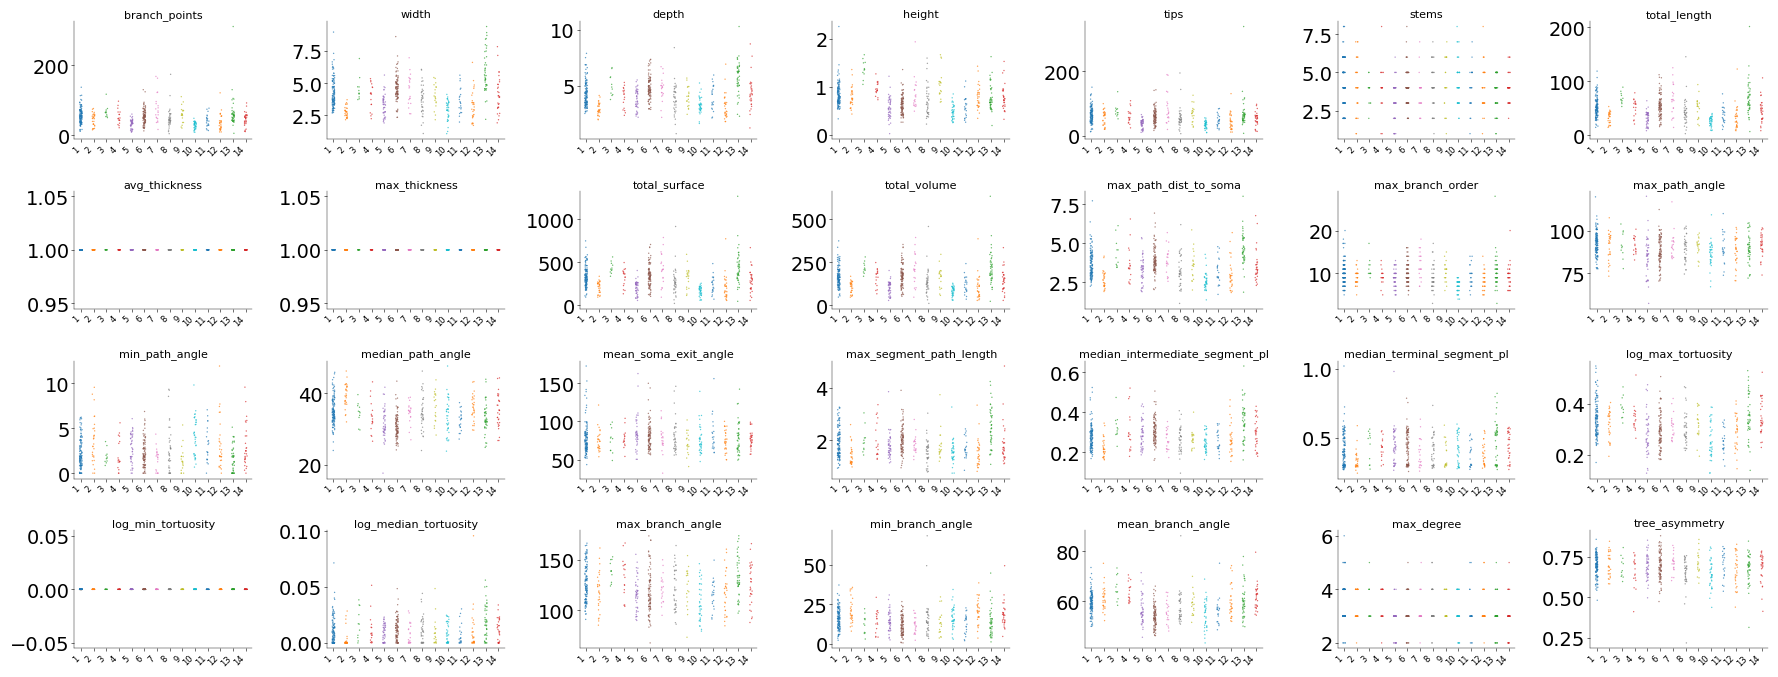

In [141]:
features = morphometric_statistics.columns.values

fig, axes = plt.subplots(4, 7, figsize=(18, 7))
axes = axes.flatten()

# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------

for i, feature in enumerate(features):

    if len(features) > len(axes):
        raise ValueError("Not enough axes to plot all features.")

    ax = axes[i]
    sns.stripplot(
        data=stats_with_labels,
        x="cluster",
        y=feature,
        ax=ax,
        jitter=True,
        size=2,
        alpha=0.7,
        palette="tab10",
    )
    ax.set_title(feature, fontsize=8)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=6)
    ax.set_ylabel("")

fig.tight_layout()
plt.show()

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

**Answer:**

- Uninformative statistics/features: 
- avg_thickness, max_thickness,  log_min_tortuosity do not vary at al between the different clusters, so they can be removed
- since thickness is constant, total_volume and total_surface are identical to total_length, so they can be removed as well
- all other statistics show variation across clusters
- Informative statistics/features: width, depth, height, tips, branch_points, total_length, total_surface, mean_soma_exit_angle, max_path_angle, median_path_angle (and basically all others except the 5 uninformative features we identified)

2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

**Answer:**

Morphometric statistics capture global and local properties of the morphology of neurons. Features like Tree depth, width, branch points, angles, and path lengths describe the structure and geometry of a neuron and act as biologically interpretable features for analysing the morphological properties of neurons.
One further advantage is that each neuron becomes a fixed-length feature vector, which is easy to store, visualize, and analyse.

Downsides and limitations of morphometric statistics are a potential loss of spatial detail, such that two neurons with differing shapes have identical/similar summary statistics. Morphometric statistics also lack a local Context and Morphology Dynamics, i.e. for statistics like branch order or segment angle we don´t know where in the neuron we find the corresponding morphological features. The statistics are quite susceptible to noise which is a problem since depending on the way the neurons are reconstruced a single missing branch can have a rather big affect on features like total length or tip count.

## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [142]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_with_clusters.drop(features_to_drop, axis=1)

# Separate features and cluster labels
features = morphometric_data.drop(columns="cluster")
clusters = morphometric_data["cluster"]

# Z-score normalization of features only
features = (features - features.mean()) / features.std()

# Replace NaNs (e.g., from division by zero std) with 0
features = features.fillna(0)

# Combine normalized features and clusters back into a single DataFrame if needed
morphometric_standardized = features.copy()
morphometric_standardized["cluster"] = clusters

In [143]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them  for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------

all_x, all_y, all_z = [], [], []

for neuron in neurons:
    for node in neuron._G.nodes:
        pos = neuron._G.nodes[node]["pos"]
        all_x.append(pos[0])
        all_y.append(pos[1])
        all_z.append(pos[2])

# Convert to arrays
all_x, all_y, all_z = np.array(all_x), np.array(all_y), np.array(all_z)

# Print global coordinate ranges
print(f"x range: {all_x.min():.2f} – {all_x.max():.2f}")
print(f"y range: {all_y.min():.2f} – {all_y.max():.2f}")
print(f"z range: {all_z.min():.2f} – {all_z.max():.2f}")

x range: -6.34 – 5.14
y range: -5.49 – 5.36
z range: -1.50 – 1.86


In [144]:
from morphopy.computation.feature_presentation import compute_density_maps

config_global = dict(
    # ---------------------------------------------------------------------------------
    # complete the config dict and compute the z-density maps for each neuron (1 pts)
    # ---------------------------------------------------------------------------------
    distance=1,
    n_bins_x=20,
    n_bins_y=20,
    n_bins_z=20,
    density=True,
    smooth=True,
    sigma=1,
    r_min_x=all_x.min(),
    r_max_x=all_x.max(),
    r_min_y=all_y.min(),
    r_max_y=all_y.max(),
    r_min_z=all_z.min(),
    r_max_z=all_z.max(),
    projection=["x", "y", "z"],
)

# compute density maps per neuron
density_maps = [compute_density_maps(n, config_params=config_global) for n in neurons]
# extract only the z-projection
dm_z = np.array([dm["z_proj"]["data"] for dm in density_maps])  # shape: (N_neurons, 20)

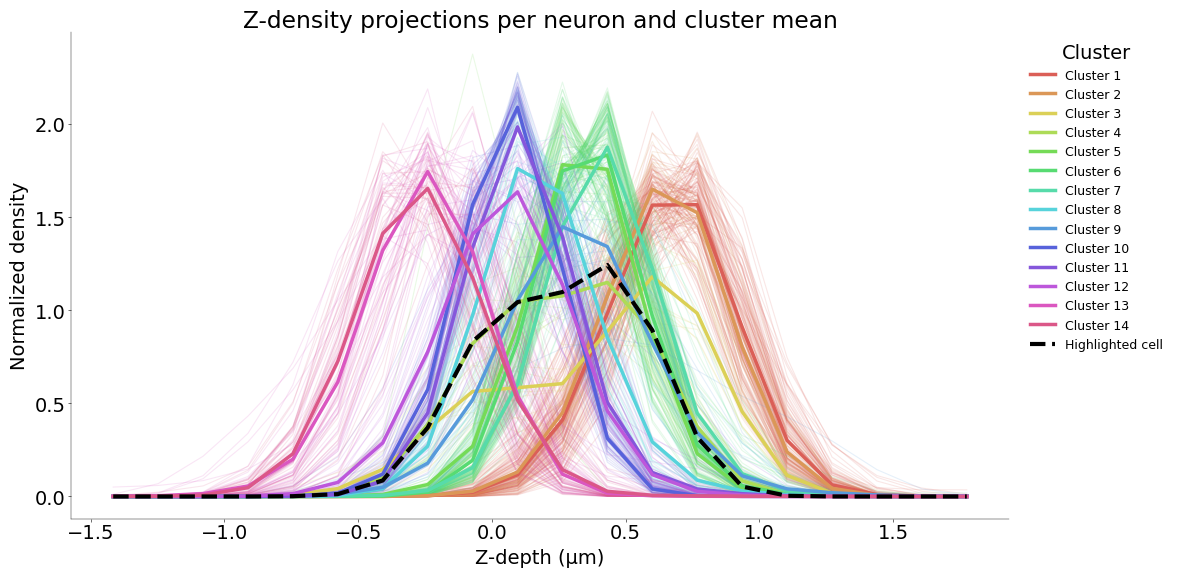

In [ ]:
# extract z-projection data for all neurons
dm_z = np.array([density["z_proj"]["data"] for density in density_maps])
z_edges = density_maps[0]["z_proj"]["edges"][0]  # Use bin edges from any sample
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])  # Midpoints of bins

# Extract aligned cluster IDs and sort them
cluster_ids = morphometric_standardized["cluster"].values
sorted_indices = np.argsort(cluster_ids)

# Sort density maps and labels
dm_z_sorted = dm_z[morphometric_standardized.index.values.argsort()][sorted_indices]
clusters_sorted = cluster_ids[sorted_indices]

# plot individual and mean curves per cluster
unique_clusters = np.unique(clusters_sorted)
palette = sns.color_palette("hls", len(unique_clusters))

plt.figure(figsize=(12, 6))

# Plot all individual curves
for cluster_idx, cluster in enumerate(unique_clusters):
    cluster_mask = clusters_sorted == cluster
    cluster_curves = dm_z_sorted[cluster_mask]
    for curve in cluster_curves:
        plt.plot(
            z_centers, curve, color=palette[cluster_idx], alpha=0.15, linewidth=0.8
        )

# Plot cluster means
for cluster_idx, cluster in enumerate(unique_clusters):
    cluster_mask = clusters_sorted == cluster
    mean_curve = dm_z_sorted[cluster_mask].mean(axis=0)
    plt.plot(
        z_centers,
        mean_curve,
        color=palette[cluster_idx],
        label=f"Cluster {cluster}",
        linewidth=2.5,
    )

# highlight specific cell (from task 1)
# search for cell 
highlight_cell = "0060_00556_3R_C02_01"
files = sorted(f for f in os.listdir(data_dir) if f.endswith(".swc"))
cell_names = [f.replace(".swc", "") for f in files]
# get the index of the target cell
highlight_idx = cell_names.index(highlight_cell)
highlight_curve = dm_z[highlight_idx]
plt.plot(
    z_centers,
    highlight_curve,
    color="black",
    linewidth=3,
    linestyle="--",
    label="Highlighted cell",
)

# final plot formatting
plt.xlabel("Z-depth (µm)")
plt.ylabel("Normalized density")
plt.title("Z-density projections per neuron and cluster mean")
plt.legend(title="Cluster", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
for cluster in unique_clusters:
    cluster_mask = clusters_sorted == cluster
    mean_curve = dm_z_sorted[cluster_mask].mean(axis=0)
    peak_value = mean_curve.max()
    peak_index = mean_curve.argmax()
    peak_z = z_centers[peak_index]
    print(f"Cluster {cluster}: Peak density = {peak_value:.4f} at Z ≈ {peak_z:.2f} µm")

Cluster 1: Peak density = 1.5663 at Z ≈ 0.77 µm
Cluster 2: Peak density = 1.6498 at Z ≈ 0.60 µm
Cluster 3: Peak density = 1.1797 at Z ≈ 0.60 µm
Cluster 4: Peak density = 1.1492 at Z ≈ 0.43 µm
Cluster 5: Peak density = 1.7810 at Z ≈ 0.26 µm
Cluster 6: Peak density = 1.8336 at Z ≈ 0.43 µm
Cluster 7: Peak density = 1.8750 at Z ≈ 0.43 µm
Cluster 8: Peak density = 1.7600 at Z ≈ 0.10 µm
Cluster 9: Peak density = 1.4477 at Z ≈ 0.26 µm
Cluster 10: Peak density = 2.0890 at Z ≈ 0.10 µm
Cluster 11: Peak density = 1.9837 at Z ≈ 0.10 µm
Cluster 12: Peak density = 1.6354 at Z ≈ 0.10 µm
Cluster 13: Peak density = 1.7439 at Z ≈ -0.24 µm
Cluster 14: Peak density = 1.6532 at Z ≈ -0.24 µm


### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:**
The Z-density maps provides a cross-sectional look at how different retinal ganglion cell (RGC) types/cell clusters arborize along the Z-axis — i.e., through the depth of the inner plexiform layer (IPL). It reflects laminar depth in the retina, from inner (closer to ganglion cell layer) to outer (closer to bipolar/amacrine layers) with each curve representing the average arbor density along this depth for all cells in a cluster. Since ON and OFF pathways stratify at different depths in the IPL, Z-density maps are a useful proxy for functional type classification.

- some cluster exhibit a distinct peak along the Z-axis, suggesting that each of these neuron types arborizes at a characteristic IPL depth
- some examples for such a cluster specific patterns are:
    - Cluster 1 & 2 arborize deep in the IPL (~0.6–0.77 µm)
    - Clusters 13 & 14 peak in the outer IPL (~−0.24 µm)
- the ordering reflects laminar organization
--> there is a clear progression from negative Z (outer layers of the retina) to positive Z (inner layers) with specific clusters across the depth (note: all clusters show some overlap)

- the positions of the peaks are stable and tightly grouped within clusters (as shown by the mean denisty profiles), suggesting strong morphological identity within clusters along the z dimension


For example:
- Cluster 10 and 11 have the sharpest and most localized peak (Cluster 10: Peak density = 2.0890 at Z ≈ 0.10 µm, Cluster 11: Peak density = 1.9837 at Z ≈ 0.10 µm), indicating a narrow stratification layer. 
- The peaks of clusters like 3, 4 and 9 are much lower (Cluster 3: Peak density = 1.1797,Cluster 4: Peak density = 1.149, Cluster 9: Peak density = 1.4477 at Z ≈ 0.26 µm), but these also have broader z-density profiles which hints at more diffuse arbors and that cells from these clusters integrate across depth/multiple layers of IPL


So we can say that Z-density profiles are helpful for getting an idea about RGC types, especially for:
- ON vs. OFF vs. bistratified types
- narrow vs. diffuse arbor types

2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:**

Based on the Z-density maps and the plot from Task 1:

We look for clusters with broad and/or bimodal density profiles, not sharp single peaks, which indicates dendrites spanning two/muliple layers.
Likely candidates therefore are clusters 3 and 4, most likely cluster 4 due to it´s range across z. In our plot above we can verify this, by highlighting this specific cell.


## Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [ ]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------

y = morphometric_standardized["cluster"].values
X_morpho = morphometric_standardized.drop("cluster", axis=1).values

# align your density‐map array (dm_z) to the same cells
#    build a mapping from Cell_nr → row index in dm_z
cell_to_idx = {cell: i for i, cell in enumerate(morphometric_standardized.index)}
aligned_idx = [cell_to_idx[cell] for cell in morphometric_standardized.index]
X_density = dm_z[aligned_idx]

# t-SNE on each representation
tsne_morpho = TSNE(perplexity=100, random_state=17)
embedding_morpho = tsne_morpho.fit(X_morpho)

tsne_density = TSNE(perplexity=100, random_state=17)
embedding_density = tsne_density.fit(X_density)

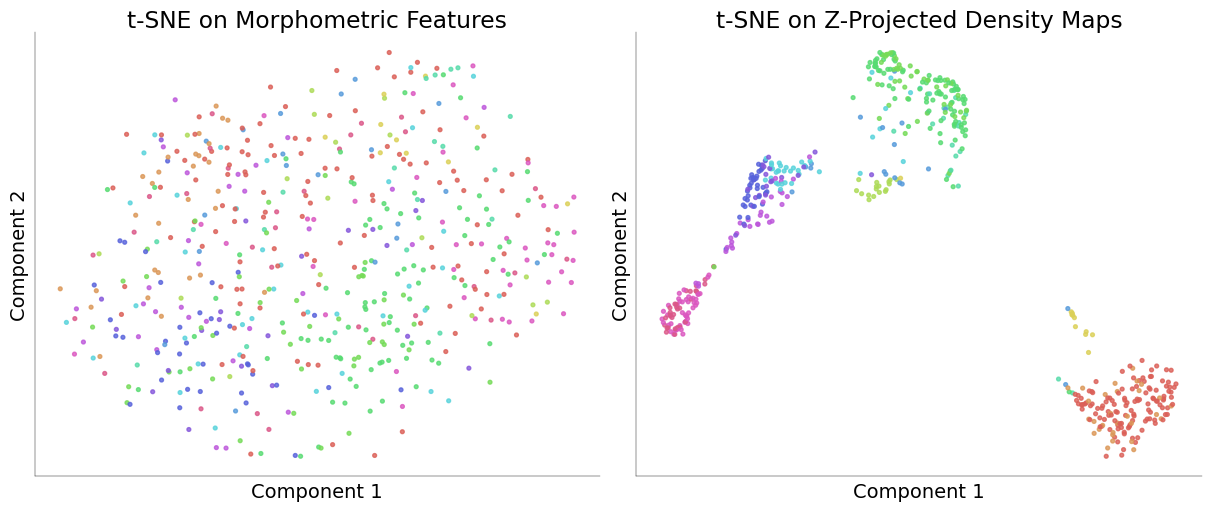

In [ ]:
# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------
from matplotlib.colors import ListedColormap

# Create color palette with 'hls' for distinct colors
palette = sns.color_palette("hls", len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, palette))

# Map cluster labels to colors
colors_array = np.array([cluster_color_map[c] for c in y])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

# -- Morphometric t-SNE --
axes[0].scatter(
    embedding_morpho[:, 0],
    embedding_morpho[:, 1],
    c=colors_array,
    s=30,
    alpha=0.8,
)
axes[0].set_title("t-SNE on Morphometric Features")
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].set_xticks([])
axes[0].set_yticks([])

# -- Density-map t-SNE --
axes[1].scatter(
    embedding_density[:, 0],
    embedding_density[:, 1],
    c=colors_array,
    s=30,
    alpha=0.8,
)
axes[1].set_title("t-SNE on Z-Projected Density Maps")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:**

 - t-SNE results show that Z-density maps capture more discriminative structure for clustering our retinal cells than morphometric statistics
 - Morphometric statistics: while interpretable, don’t separate RGC types strongly in t-SNE space. This can be seen because:
--> Data points are diffuse and overlapping
--> No clearly defined clusters
--> Colors (cell type/cluster labels) are intermixed across the space
This  might be due to:
- --> Some features being correlated or redundant
- --> Noisy or overlapping distributions across clusters

- Density Maps: 
(Z-density map specifically represents where dendritic branches are located in retinal depth, reflecting laminar stratification)
(note: spatial proximity in t-SNE reflects similarity in Z-density profiles)

Some clusters form tight, compact groups which represent RGC types with highly consistent stratification profiles, meaning: Their dendrites arborize at similar depths in the inner plexiform layer (IPL). Other clusters are more dispersed which indicates more diffuse or broader arbors: cells arborize over a larger depth range (see cluster 3 and 4 in Task 3 plot). Interestingly, several tight t-SNE clusters contain points from two different labels. This suggests that two biologically distinct cell types share nearly identical Z-density profiles (this is somethig that becomes also clear when looking at the z-denisty profile of task 3). This could be because these have nearly identical stratification, but possibly differ along other feature dimensions like lateral extent, branching complexity, or axonal projection


possible reasons for this might be:
- direct encoding of stratification patterns: Z-densities reflect where in the IPL a cell arborizes. Since RGC types are often classified by depth (ON, OFF, bistratified), this representation directly encodes functionally relevant information
- morphometrics are too general: morphometric features like width, height, and branch points are not spatially aligned or directly comparable across cells and don't necessarily reflect the functional layer the cell resides in
- less intra-class variability: Z-density maps lead to less within-class variance, making classes easier to separate in feature space.


The Z-projected density maps provide a much better clustering than morphometric features, likely because they more directly capture the functionally meaningful laminar organization of retinal ganglion cell types.

2) What are the advantages of morphometric statistics over density maps 

**Answer:**

- interpretable: feature s(e.g., branch points, soma exit angle) are biologically meaningful
- compact: Fixed scalar values per neuron
- easy to compute and store
- suited for ML
- covers global shape: Captures tree-wide metrics like total length, width, etc

but: may miss spatial specificity, less sensitive to stratification pattern

3) What are the advantages of density maps over morphometric statistics 

**Answer:**

- capture spatial patterns: Directly encode where the neuron arborizes
- highly discriminative for RGCs: stratification depth differ between retinal cell types
- expressive: Ccn reflect subtle shape differences that global stats miss

but: require binning decision and these bins lack direct biological meaning (less intuitive than named features like “max path length”), more memory intensive, parameter sensitivity (depend on bin size, range, and smoothing — choices may affect the result)


## Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [ ]:
# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
random_seed = 42

# Prepare target labels
y = labels["projection_site"].values

# Define stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Initialize scaler
scaler = StandardScaler()

# ----- Morphometric Data -----
X_morpho = scaler.fit_transform(X_morpho)

log_reg_morpho = LogisticRegressionCV(
    cv=cv,
    multi_class="multinomial",
    max_iter=1000,
    solver="lbfgs",
    scoring="accuracy",
    random_state=random_seed,
)

log_reg_morpho.fit(X_morpho, y)
scores_morpho = cross_val_score(log_reg_morpho, X_morpho, y, cv=cv, scoring="accuracy")

# ----- Z-Density Data -----
X_density = scaler.fit_transform(dm_z)

log_reg_density = LogisticRegressionCV(
    cv=cv,
    multi_class="multinomial",
    max_iter=1000,
    solver="lbfgs",
    scoring="accuracy",
    random_state=random_seed,
)

log_reg_density.fit(X_density, y)
scores_density = cross_val_score(
    log_reg_density, X_density, y, cv=cv, scoring="accuracy"
)

# ----- Print Results -----
print(f"Mean cross-validated accuracy (Morphometric): {scores_morpho.mean():.4f}")
print(f"Mean cross-validated accuracy (Z-densities):  {scores_density.mean():.4f}")

Mean cross-validated accuracy (Morphometric): 0.7564
Mean cross-validated accuracy (Z-densities):  0.6836


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

im widersprch zu unseren Ergebnissen

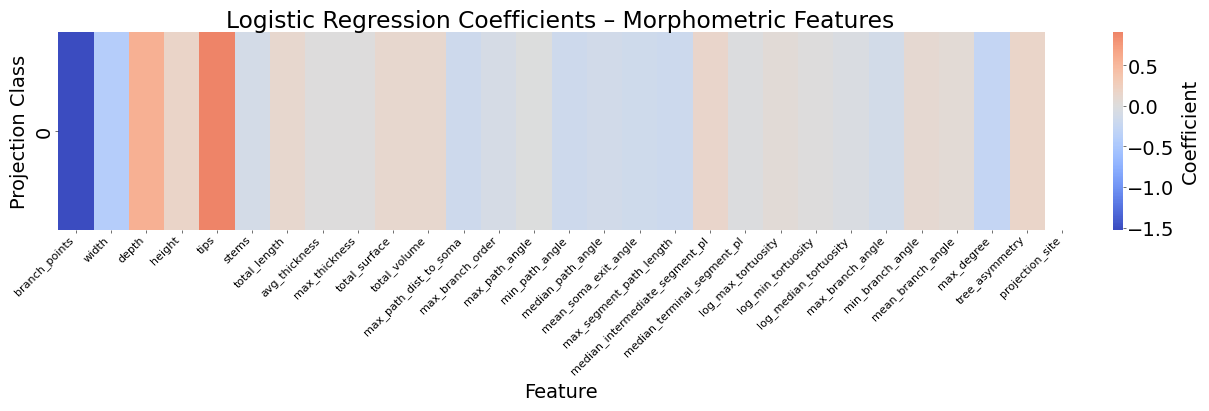

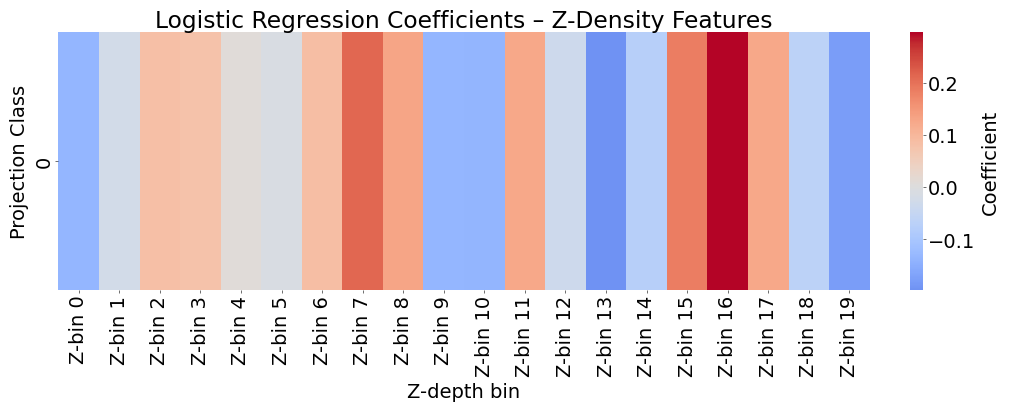

In [ ]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------


# Morphometric features
plt.figure(figsize=(12, 4))
sns.heatmap(
    clf_morpho.coef_,
    xticklabels=morpho_df.columns,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Coefficient"},
)
plt.title("Logistic Regression Coefficients – Morphometric Features")
plt.xlabel("Feature")
plt.ylabel("Projection Class")
plt.xticks(rotation=45, ha="right", fontsize=8)
# plt.tight_layout()
plt.show()

# Z-density features
plt.figure(figsize=(10, 4))
sns.heatmap(
    clf_density.coef_,
    xticklabels=[f"Z-bin {i}" for i in range(X_density.shape[1])],
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Coefficient"},
)
plt.title("Logistic Regression Coefficients – Z-Density Features")
plt.xlabel("Z-depth bin")
plt.ylabel("Projection Class")
plt.show()

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:**

## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)